## 1. Import Required Libraries

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import warnings
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.calibration import CalibratedClassifierCV

In [2]:
RANDOM_STATE = 42
DATA_PATH = "Final_Reviews.csv"

# Columns in the dataset
COL_RATING = "rating"
COL_TITLE  = "title"
COL_TEXT   = "text"

## 2. Load the Dataset

In [3]:
df = pd.read_csv("Final_Reviews.csv")

df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,Great family movie,Enjoyed by the whole family.,[],B00S0B2496,B00S0B2496,AEA2QL4BERSQ5E2HXAGOXKW2QHEA,2018-08-01 04:16:01.037,0,True
1,1,Unsatisfied,"The case that it came in was black and blank, ...",[],B007X4ECMI,B007X4ECMI,AHYEGKMF4VOAHMKHRVAAAL7SVO6A,2013-01-16 15:49:56.000,1,True
2,2,Disappointing,Disappointing.....I expected more than a bunch...,[],B00ABD0M54,B00ABD0M54,AFDFX6ZO4D4F4VTB7VGN4RDNNLWQ,2012-12-10 18:56:25.000,2,True
3,5,Five Stars,Amazing movie! Loved it!!,[],B01CH2GQYM,B01CH2GQYM,AG7CONMMBZSCCNXQYY5PMAO7BOWQ,2017-05-16 03:20:49.000,0,True
4,5,A Must See,Magnificent - doesn't begin to describe. Mich...,[],B001MYIPYQ,B001MYIPYQ,AHZDTAGXCG7TEUYZ4UQ2LJZXWTMA,2013-06-21 16:54:22.000,1,True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rating             60000 non-null  int64 
 1   title              59996 non-null  object
 2   text               60000 non-null  object
 3   images             60000 non-null  object
 4   asin               60000 non-null  object
 5   parent_asin        60000 non-null  object
 6   user_id            60000 non-null  object
 7   timestamp          60000 non-null  object
 8   helpful_vote       60000 non-null  int64 
 9   verified_purchase  60000 non-null  bool  
dtypes: bool(1), int64(2), object(7)
memory usage: 4.2+ MB


## 3. Exploratory Data Analysis (EDA)

### 3.1. Sentiment distribution from ratings

In [5]:
positive_count = df[df["rating"].isin([4, 5])].shape[0]
negative_count = df[df["rating"].isin([1, 2])].shape[0]

sentiment_counts = {
    "Positive": positive_count,
    "Negative": negative_count,
}

sentiment_counts

{'Positive': 30000, 'Negative': 30000}

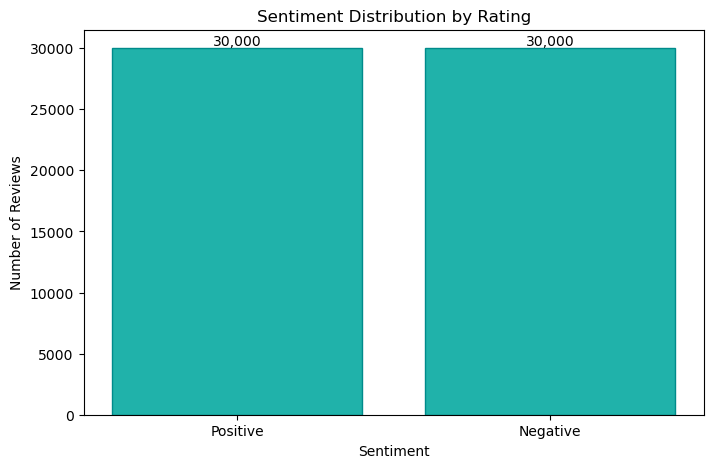

In [6]:
# Bar plot for sentiment distribution

labels = list(sentiment_counts.keys())
values = list(sentiment_counts.values())

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color='lightseagreen', edgecolor='darkcyan')
plt.title("Sentiment Distribution by Rating")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")

for i, v in enumerate(values):
    plt.text(i, v, f"{v:,}", ha="center", va="bottom")
    
plt.savefig("sentiment_distribution_main.png", dpi=300, bbox_inches='tight')

plt.show()

### 3.2. Review text length distribution

In [7]:
text_length = df["text"].str.len()

text_length.describe()

count    60000.000000
mean       318.051933
std        648.167235
min          1.000000
25%         54.000000
50%        130.000000
75%        307.000000
max      31232.000000
Name: text, dtype: float64

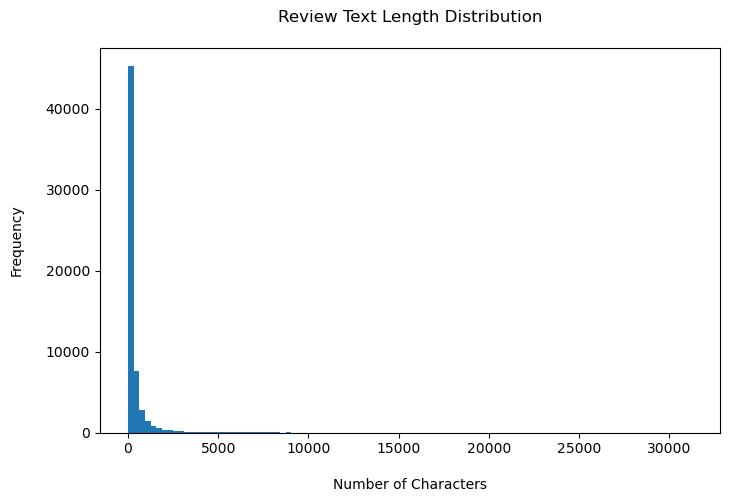

In [8]:
plt.figure(figsize=(8, 5))
plt.hist(text_length.values, bins=100)
plt.title("Review Text Length Distribution\n")
plt.xlabel("\nNumber of Characters")
plt.ylabel("Frequency\n")
plt.savefig("text_length_distribution_main.png", dpi=300, bbox_inches='tight')
plt.show()

### 3.3. Word count vs sentiment

In [9]:
df["sentiment_tmp"] = df["rating"].apply(
    lambda x: "Positive" if x >= 4 else "Negative"
)

df["word_count_tmp"] = df["text"].str.split().str.len()

positive_lengths = df[df["sentiment_tmp"] == "Positive"]["word_count_tmp"]
negative_lengths = df[df["sentiment_tmp"] == "Negative"]["word_count_tmp"]

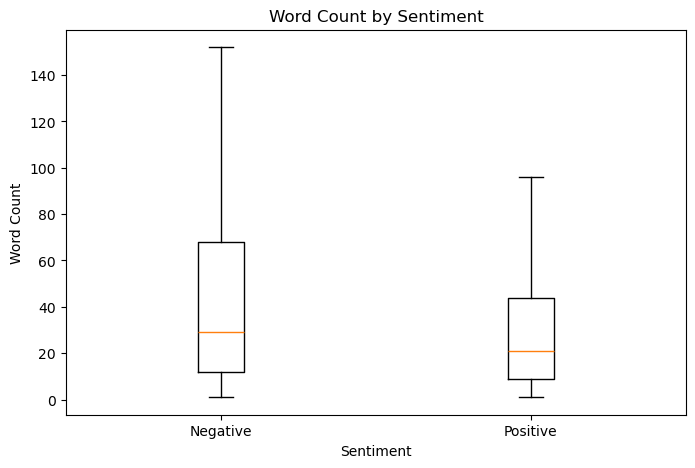

In [10]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(8, 5))
plt.boxplot([negative_lengths, positive_lengths], labels=["Negative", "Positive"], showfliers=False)
plt.title("Word Count by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Word Count")
plt.savefig("word_count_by_sentiment_main.png", dpi=300, bbox_inches='tight')
plt.show()

### 3.4. Duplicate review check

In [11]:
duplicate_text_count = df.duplicated(subset=["text"]).sum()
print("Duplicate review texts:", duplicate_text_count)

Duplicate review texts: 0


### 3.5. Word Frequency Analysis

In [12]:
def tokenize_basic(text: str) -> list[str]:
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return text.split()

##### Collect tokens by sentiment

In [13]:
tokens_by_sentiment = {
    "Positive": [],
    "Negative": []
}

for sentiment, group in df.groupby("sentiment_tmp"):
    for text in group["text"]:
        tokens_by_sentiment[sentiment].extend(tokenize_basic(text))

#### 3.5.1 Most common words (raw tokens)

In [14]:
# top 10 raw words 

top_n = 10

positive_common = Counter(tokens_by_sentiment["Positive"]).most_common(top_n)
negative_common = Counter(tokens_by_sentiment["Negative"]).most_common(top_n)

df_positive_words = pd.DataFrame(positive_common, columns=["word", "count"])
df_negative_words = pd.DataFrame(negative_common, columns=["word", "count"])

In [15]:
df_positive_words

,word,count
0,the,78145
1,and,45075
2,a,39087
3,of,33006
4,to,32481
5,i,28116
6,is,26153
7,it,24674
8,this,23734
9,in,19903


In [16]:
df_negative_words

,word,count
0,the,101671
1,and,49808
2,a,47888
3,to,45929
4,of,41000
5,i,38440
6,it,33173
7,this,30884
8,is,30107
9,in,24748


#### 3.5.2. Tokenization with stopword filtering

In [17]:
stop_words = set(ENGLISH_STOP_WORDS) - {"not", "no"}

def tokenize_filtered(text: str) -> list[str]:
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return [
        w for w in text.split()
        if w not in stop_words and len(w) > 2
    ]

#### Recompute frequent unigrams (filtered)

In [18]:
filtered_tokens = {
    "Positive": [],
    "Negative": []
}

for sentiment, group in df.groupby("sentiment_tmp"):
    for text in group["text"]:
        filtered_tokens[sentiment].extend(
            tokenize_filtered(text)
        )

In [19]:
positive_unigrams = Counter(filtered_tokens["Positive"]).most_common(top_n)
negative_unigrams = Counter(filtered_tokens["Negative"]).most_common(top_n)

df_positive_unigrams = pd.DataFrame(positive_unigrams, columns=["word", "count"])
df_negative_unigrams = pd.DataFrame(negative_unigrams, columns=["word", "count"])

In [20]:
df_positive_unigrams

,word,count
0,movie,13609
1,great,8677
2,not,7461
3,good,6935
4,love,5915
5,like,5163
6,film,4882
7,story,4330
8,watch,4021
9,just,3978


In [21]:
df_negative_unigrams

,word,count
0,movie,17880
1,not,17157
2,just,9214
3,like,8745
4,film,6568
5,good,5691
6,time,4986
7,really,4700
8,story,4670
9,bad,4653


#### 3.5.3. N-gram Phrase Analysis (Bigrams/Trigrams + Log Ratio)

In [22]:
# Text cleaning function for vectorization
def clean_text_for_vectorizer(text: str) -> str:
    if not isinstance(text, str):
        text = "" if pd.isna(text) else str(text)

    text = re.sub(r"<br\s*/?>", " ", text)      # remove HTML breaks
    text = re.sub(r"[^a-zA-Z\s]", " ", text)    # keep letters/spaces only
    text = re.sub(r"\s+", " ", text).strip()    # normalize whitespace
    return text.lower()

In [23]:
# Build a clean text column for phrase analysis
# Clean Column for Phrase Mining
df["clean_text_tmp"] = df["text"].apply(clean_text_for_vectorizer)

empty_rows = (df["clean_text_tmp"].str.len() == 0).sum()
print("Empty clean_text rows:", empty_rows)

Empty clean_text rows: 36


In [24]:
# Vectorize phrases (bigrams + trigrams)
# CountVectorizer for Phrases
vectorizer = CountVectorizer(
    ngram_range=(2, 3),
    min_df=100,           # keep only frequent phrases
    stop_words=None
)

X_phrases = vectorizer.fit_transform(df["clean_text_tmp"])
phrases = vectorizer.get_feature_names_out()

print("Phrase matrix shape:", X_phrases.shape)
print("Sample phrases:", phrases[:10])

Phrase matrix shape: (60000, 3572)
Sample phrases: ['ability to' 'able to' 'about as' 'about her' 'about his' 'about how'
 'about it' 'about minutes' 'about the' 'about this']


In [25]:
# Compute class-wise phrase frequencies
# Phrase Frequencies by Class
pos_mask = (df["sentiment_tmp"] == "Positive").values
neg_mask = (df["sentiment_tmp"] == "Negative").values

pos_counts = np.asarray(X_phrases[pos_mask].sum(axis=0)).ravel()
neg_counts = np.asarray(X_phrases[neg_mask].sum(axis=0)).ravel()

phrase_stats = pd.DataFrame({
    "phrase": phrases,
    "positive_freq": pos_counts,
    "negative_freq": neg_counts
})

#### Log-ratio scoring (positive vs negative)

In [26]:
phrase_stats["log_ratio"] = np.log(
    (phrase_stats["positive_freq"] + 1) /
    (phrase_stats["negative_freq"] + 1)
)

top_n = 10
top_positive_phrases = phrase_stats.sort_values("log_ratio", ascending=False).head(top_n)
top_negative_phrases = phrase_stats.sort_values("log_ratio", ascending=True).head(top_n)

In [27]:
top_positive_phrases

,phrase,positive_freq,negative_freq,log_ratio
3193,wait for season,120,1,4.102643
2143,really enjoyed this,157,2,3.963983
1076,highly recommend this,143,2,3.871201
540,can wait for,239,5,3.688879
1077,highly recommended,179,4,3.583519
539,can wait,452,15,3.343303
750,excellent movie,161,5,3.295837
3342,well worth,235,9,3.161247
541,can wait to,160,6,3.135494
1585,loves this,158,6,3.122994


In [28]:
top_negative_phrases

,phrase,positive_freq,negative_freq,log_ratio
664,don waste your,2,579,-5.264416
3286,waste your time,2,514,-5.145555
3373,what waste,0,162,-5.093750
3284,waste your,4,751,-5.013298
3486,worst movies,0,139,-4.941642
3374,what waste of,0,134,-4.905275
663,don waste,4,637,-4.848900
2745,the worst movies,0,123,-4.820282
3106,total waste,0,112,-4.727388
3107,total waste of,0,103,-4.644391


In [29]:
def plot_top_phrases(df_phrases: pd.DataFrame, title: str, filename: str) -> None:
    plt.figure(figsize=(8, 4))
    plt.barh(df_phrases["phrase"], df_phrases["log_ratio"],
             color='skyblue', edgecolor='steelblue')
    plt.title(title)
    plt.xlabel("Log Ratio")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

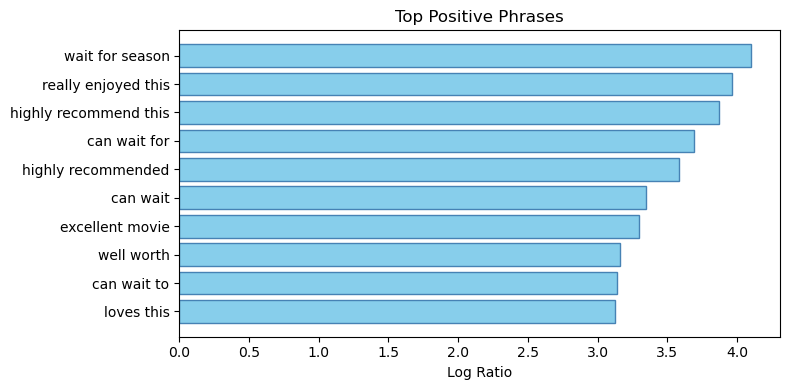

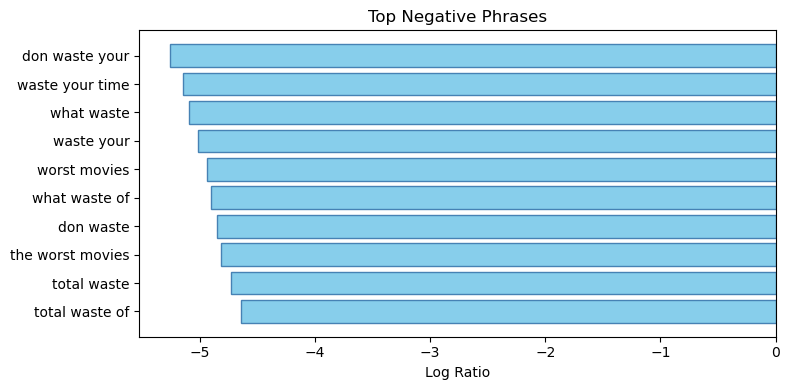

In [30]:
plot_top_phrases(top_positive_phrases, "Top Positive Phrases", "positive_phrases.png")
plot_top_phrases(top_negative_phrases, "Top Negative Phrases", "negative_phrases.png")

In [31]:
# Remove temporary columns used only for EDA
df.drop(columns=["sentiment_tmp", "clean_text_tmp"], inplace=True)

## 4. Data Preparation
#### Preparing the data for model training including creating labels, cleaning text, and splitting into train/test sets.

### 4.1. Create binary sentiment label (model target)

In [32]:
# Binary sentiment:
# 1 → Positive (rating >= 4)
# 0 → Negative (rating <= 2)
df["sentiment"] = df["rating"].apply(
    lambda x: 1 if x >= 4 else 0
)

df["sentiment"].value_counts()

sentiment
1    30000
0    30000
Name: count, dtype: int64

### 4.2. Remove duplicate reviews (before split)

In [33]:
before_count = len(df)

df = df.drop_duplicates(
    subset=["title", "text"]
).reset_index(drop=True)

after_count = len(df)

print("Before deduplication:", before_count)
print("After deduplication :", after_count)
print("Removed duplicates :", before_count - after_count)

Before deduplication: 60000
After deduplication : 60000
Removed duplicates : 0


### 4.3. Text cleaning

In [34]:
def clean_text_basic(text: str) -> str:
    if not isinstance(text, str):
        text = "" if pd.isna(text) else str(text)

    text = re.sub(r"<br\s*/?>", " ", text)   # remove HTML breaks
    text = re.sub(r"\s+", " ", text)         # normalize whitespace
    return text.lower().strip()

#### Clean title and review text

In [35]:
df["title_clean"] = df["title"].apply(clean_text_basic)
df["text_clean"] = df["text"].apply(clean_text_basic)

df[["title", "title_clean", "text", "text_clean"]].head(2)

,title,title_clean,text,text_clean
0,Great family movie,great family movie,Enjoyed by the whole family.,enjoyed by the whole family.
1,Unsatisfied,unsatisfied,"The case that it came in was black and blank, ...","the case that it came in was black and blank, ..."


### 4.4. Create final modeling text (Title + Text)

In [36]:
df["full_text"] = (df["title_clean"] + " " + df["text_clean"]).str.strip()

empty_rows = (df["full_text"].str.len() == 0).sum()
print("Empty full_text rows:", empty_rows)

Empty full_text rows: 0


### 4.5. Train-Test Split

In [37]:
X = df["full_text"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=RANDOM_STATE,stratify=y)

print("Train size:", X_train.shape)
print("Test size :", X_test.shape)

print("Train label distribution:", y_train.value_counts().to_dict())
print("Test label distribution :", y_test.value_counts().to_dict())

Train size: (48000,)
Test size : (12000,)
Train label distribution: {1: 24000, 0: 24000}
Test label distribution : {1: 6000, 0: 6000}


## 5. Feature Extraction (TF-IDF)
#### Converting text data into numerical features using TF-IDF (Term Frequency-Inverse Document Frequency) vectorization with unigrams and bigrams.

In [38]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),     # unigrams + bigrams
    min_df=5,               # ignore very rare words
    max_df=0.9,             # ignore extremely common words
    sublinear_tf=True       # log-scaled term frequency
)

### 5.1. Fit on train, transform train & test

In [39]:
# Text to TF-IDF features

X_train = tfidf.fit_transform(X_train)
X_test  = tfidf.transform(X_test)

print("Train feature shape:", X_train.shape)
print("Test feature shape :", X_test.shape)

Train feature shape: (48000, 81400)
Test feature shape : (12000, 81400)


### 5.2. Feature space sanity check

In [40]:
feature_names = tfidf.get_feature_names_out()

print("Number of features:", len(feature_names))
print("Sample features:", feature_names[:20])

Number of features: 81400
Sample features: ['00' '00 and' '00 for' '000' '000 000' '000 feet' '000 years' '007' '01'
 '02' '04' '07' '08' '09' '10' '10 00' '10 000' '10 10' '10 15' '10 20']


## 6. Model Training
#### Training three different classification models to establish baseline performance before tuning and ensemble methods.

### 6.1. Model Training and Evaluation Helper Function

In [41]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name: str):
    """
    Trains a model and prints standard classification metrics.
    Returns accuracy for comparison.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)

    print(f"\n{model_name}")
    print("-" * len(model_name))
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))

    return acc

### 6.2. Logistic Regression

In [42]:
log_reg = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

acc_lr = train_and_evaluate(
    log_reg,
    X_train, y_train,
    X_test, y_test,
    model_name="Logistic Regression"
)


Logistic Regression
-------------------
Accuracy: 0.9351666666666667
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      6000
           1       0.95      0.92      0.93      6000

    accuracy                           0.94     12000
   macro avg       0.94      0.94      0.94     12000
weighted avg       0.94      0.94      0.94     12000



### 6.3. Multinomial Naive Bayes

In [43]:
nb = MultinomialNB()

acc_nb = train_and_evaluate(
    nb,
    X_train, y_train,
    X_test, y_test,
    model_name="Multinomial Naive Bayes"
)


Multinomial Naive Bayes
-----------------------
Accuracy: 0.9333333333333333
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      6000
           1       0.96      0.90      0.93      6000

    accuracy                           0.93     12000
   macro avg       0.93      0.93      0.93     12000
weighted avg       0.93      0.93      0.93     12000



### 6.4. Linear SVM

In [44]:
svm = LinearSVC(
    random_state=RANDOM_STATE
)

acc_svm = train_and_evaluate(
    svm,
    X_train, y_train,
    X_test, y_test,
    model_name="Linear SVM"
)


Linear SVM
----------
Accuracy: 0.9416666666666667
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      6000
           1       0.95      0.93      0.94      6000

    accuracy                           0.94     12000
   macro avg       0.94      0.94      0.94     12000
weighted avg       0.94      0.94      0.94     12000



## 7. Hyperparameter Tuning
#### Using GridSearchCV with 5-fold cross-validation to find optimal hyperparameters for each model.

### 7.1. Logistic Regression Tuning

#### Parameters:
- `C`: Regularization strength (smaller = stronger regularization, prevents overfitting)
- `penalty`: Type of regularization (l1 = Lasso, l2 = Ridge)

In [45]:
# Logistic Regression hyperparameter grid
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['saga']  # saga supports both l1 and l2
}

lr_grid_search = GridSearchCV(
    LogisticRegression(max_iter=5000, random_state=RANDOM_STATE),
    param_grid=lr_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    verbose=1
)

lr_grid_search.fit(X_train, y_train)

print(f"\nBest Parameters: {lr_grid_search.best_params_}")
print(f"Best CV Accuracy: {lr_grid_search.best_score_:.4f}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
Best CV Accuracy: 0.9411


In [46]:
# Evaluate best Logistic Regression on test set
best_lr = lr_grid_search.best_estimator_
y_pred_lr_tuned = best_lr.predict(X_test)
acc_lr_tuned = accuracy_score(y_test, y_pred_lr_tuned)

print("Tuned Logistic Regression - Test Set Performance")
print("-" * 45)
print(f"Accuracy: {acc_lr_tuned:.4f}")
print(classification_report(y_test, y_pred_lr_tuned))

Tuned Logistic Regression - Test Set Performance
---------------------------------------------
Accuracy: 0.9409
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      6000
           1       0.95      0.93      0.94      6000

    accuracy                           0.94     12000
   macro avg       0.94      0.94      0.94     12000
weighted avg       0.94      0.94      0.94     12000



### 7.2. Multinomial Naive Bayes Tuning

#### Parameters:
- `alpha`: Smoothing parameter (Laplace smoothing). Handles words not seen during training. Higher values = more smoothing.

In [47]:
# Naive Bayes hyperparameter grid
nb_param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0]
}

nb_grid_search = GridSearchCV(
    MultinomialNB(),
    param_grid=nb_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

nb_grid_search.fit(X_train, y_train)

print(f"\nBest Parameters: {nb_grid_search.best_params_}")
print(f"Best CV Accuracy: {nb_grid_search.best_score_:.4f}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Parameters: {'alpha': 0.5}
Best CV Accuracy: 0.9360


In [48]:
# Evaluate best Naive Bayes on test set
best_nb = nb_grid_search.best_estimator_
y_pred_nb_tuned = best_nb.predict(X_test)
acc_nb_tuned = accuracy_score(y_test, y_pred_nb_tuned)

print("Tuned Multinomial Naive Bayes - Test Set Performance")
print("-" * 50)
print(f"Accuracy: {acc_nb_tuned:.4f}")
print(classification_report(y_test, y_pred_nb_tuned))

Tuned Multinomial Naive Bayes - Test Set Performance
--------------------------------------------------
Accuracy: 0.9355
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      6000
           1       0.96      0.91      0.93      6000

    accuracy                           0.94     12000
   macro avg       0.94      0.94      0.94     12000
weighted avg       0.94      0.94      0.94     12000



### 7.3. Linear SVM Tuning

#### Parameters:
- `C`: Regularization parameter. Controls trade-off between smooth decision boundary and classifying training points correctly.

In [49]:
# Linear SVM hyperparameter grid
svm_param_grid = {
    'C': [0.01, 0.1, 1, 10]
}

svm_grid_search = GridSearchCV(
    LinearSVC(random_state=RANDOM_STATE, max_iter=2000),
    param_grid=svm_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Tuning Linear SVM...")
svm_grid_search.fit(X_train, y_train)

print(f"\nBest Parameters: {svm_grid_search.best_params_}")
print(f"Best CV Accuracy: {svm_grid_search.best_score_:.4f}")

Tuning Linear SVM...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best Parameters: {'C': 1}
Best CV Accuracy: 0.9405


In [50]:
# Evaluate best SVM on test set
best_svm = svm_grid_search.best_estimator_
y_pred_svm_tuned = best_svm.predict(X_test)
acc_svm_tuned = accuracy_score(y_test, y_pred_svm_tuned)

print("Tuned Linear SVM - Test Set Performance")
print("-" * 40)
print(f"Accuracy: {acc_svm_tuned:.4f}")
print(classification_report(y_test, y_pred_svm_tuned))

Tuned Linear SVM - Test Set Performance
----------------------------------------
Accuracy: 0.9417
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      6000
           1       0.95      0.93      0.94      6000

    accuracy                           0.94     12000
   macro avg       0.94      0.94      0.94     12000
weighted avg       0.94      0.94      0.94     12000



### 7.4. Hyperparameter Tuning Summary

In [51]:
# Compare default vs tuned model performance
tuning_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Multinomial Naive Bayes', 'Linear SVM'],
    'Default Accuracy': [acc_lr, acc_nb, acc_svm],
    'Tuned Accuracy': [acc_lr_tuned, acc_nb_tuned, acc_svm_tuned],
    'Best Parameters': [
        str(lr_grid_search.best_params_),
        str(nb_grid_search.best_params_),
        str(svm_grid_search.best_params_)
    ]
})

tuning_comparison['Improvement'] = tuning_comparison['Tuned Accuracy'] - tuning_comparison['Default Accuracy']
tuning_comparison

,Model,Default Accuracy,Tuned Accuracy,Best Parameters,Improvement
0,Logistic Regression,0.935167,0.940917,"{'C': 10, 'penalty': 'l2', 'solver': 'saga'}",0.005750
1,Multinomial Naive Bayes,0.933333,0.935500,{'alpha': 0.5},0.002167
2,Linear SVM,0.941667,0.941667,{'C': 1},0.000000


## 8. Ensemble Learning
#### Methods used:
- **Voting Classifier**: Combines predictions through majority vote (hard) or averaged probabilities (soft)
- **Stacking Classifier**: Uses a meta-model to learn optimal combination of base model predictions

### 8.1. Base Models(Tuned) for Ensemble

In [52]:
# Logistic Regression (tuned)
lr_ensemble = LogisticRegression(
    C=lr_grid_search.best_params_['C'],
    penalty=lr_grid_search.best_params_['penalty'],
    solver='saga',
    max_iter=1000,
    random_state=RANDOM_STATE
)

# Naive Bayes (tuned)
nb_ensemble = MultinomialNB(
    alpha=nb_grid_search.best_params_['alpha']
)

# Linear SVM (tuned)
svm_ensemble = LinearSVC(
    C=svm_grid_search.best_params_['C'],
    random_state=RANDOM_STATE,
    max_iter=2000
)

# Calibrated SVM (needed for soft voting)
calibrated_svm = CalibratedClassifierCV(svm_ensemble, cv=5)

### 8.2. Hard Voting Classifier

In [53]:
hard_voting = VotingClassifier(
    estimators=[
        ('lr', lr_ensemble),
        ('nb', nb_ensemble),
        ('svm', svm_ensemble)
    ],
    voting='hard'
)

hard_voting.fit(X_train, y_train)
y_pred_hard = hard_voting.predict(X_test)

acc_hard_voting = accuracy_score(y_test, y_pred_hard)

print(f"\nHard Voting Classifier Accuracy: {acc_hard_voting:.4f}")
print(classification_report(y_test, y_pred_hard))


Hard Voting Classifier Accuracy: 0.9430
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      6000
           1       0.95      0.94      0.94      6000

    accuracy                           0.94     12000
   macro avg       0.94      0.94      0.94     12000
weighted avg       0.94      0.94      0.94     12000



### 8.2. Soft Voting Classifier

In [54]:
soft_voting = VotingClassifier(
    estimators=[
        ('lr', lr_ensemble),
        ('nb', nb_ensemble),
        ('svm', calibrated_svm)
    ],
    voting='soft'
)

soft_voting.fit(X_train, y_train)
y_pred_soft = soft_voting.predict(X_test)

acc_soft_voting = accuracy_score(y_test, y_pred_soft)

print(f"\nSoft Voting Classifier Accuracy: {acc_soft_voting:.4f}")
print(classification_report(y_test, y_pred_soft))


Soft Voting Classifier Accuracy: 0.9433
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      6000
           1       0.95      0.93      0.94      6000

    accuracy                           0.94     12000
   macro avg       0.94      0.94      0.94     12000
weighted avg       0.94      0.94      0.94     12000



### 8.3. Stacking Classifier

In [55]:
stacking_model = StackingClassifier(
    estimators=[
        ('lr', lr_ensemble),
        ('nb', nb_ensemble),
        ('svm', svm_ensemble)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_test)

acc_stack = accuracy_score(y_test, y_pred_stack)

print(f"\nStacking Classifier Accuracy: {acc_stack:.4f}")
print(classification_report(y_test, y_pred_stack))


Stacking Classifier Accuracy: 0.9445
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      6000
           1       0.95      0.94      0.94      6000

    accuracy                           0.94     12000
   macro avg       0.94      0.94      0.94     12000
weighted avg       0.94      0.94      0.94     12000



### 8.4. Ensemble Model Comparison

In [56]:
ensemble_results = pd.DataFrame({
    'Model': [
        'Hard Voting Ensemble',
        'Soft Voting Ensemble',
        'Stacking Ensemble'
    ],
    'Accuracy': [
        acc_hard_voting,
        acc_soft_voting,
        acc_stack
    ]
})

ensemble_results

,Model,Accuracy
0,Hard Voting Ensemble,0.94300
1,Soft Voting Ensemble,0.94325
2,Stacking Ensemble,0.94450


## 9. Performance Metrics

### 9.1. Confustion Matrix

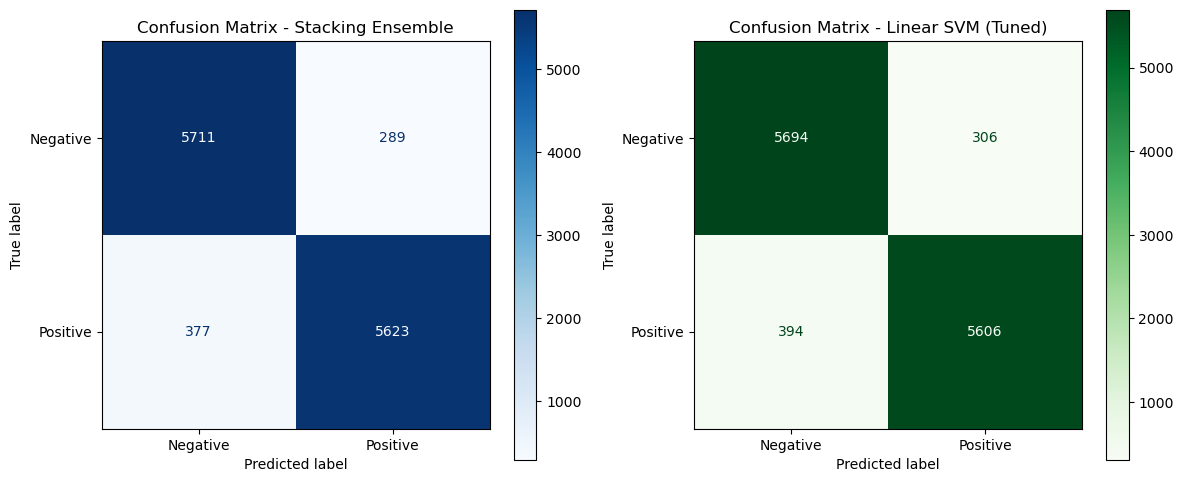

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Stacking Ensemble Confusion Matrix
cm_stack = confusion_matrix(y_test, y_pred_stack)
disp_stack = ConfusionMatrixDisplay(confusion_matrix=cm_stack, display_labels=["Negative", "Positive"])
disp_stack.plot(ax=axes[0], cmap="Blues")
axes[0].set_title("Confusion Matrix - Stacking Ensemble")


# Linear SVM (Tuned) Confusion Matrix for comparison
cm_svm = confusion_matrix(y_test, y_pred_svm_tuned)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=["Negative", "Positive"])
disp_svm.plot(ax=axes[1], cmap="Greens")
axes[1].set_title("Confusion Matrix - Linear SVM (Tuned)")

plt.savefig("confusion_matrices.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

### 9.2. ROC Curve and AUC Score

In [58]:
# Logistic Regression probabilities
y_prob_lr = best_lr.predict_proba(X_test)[:, 1]

# Naive Bayes probabilities
y_prob_nb = best_nb.predict_proba(X_test)[:, 1]

# Stacking Classifier probabilities
y_prob_stack = stacking_model.predict_proba(X_test)[:, 1]

# Calculate ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb)
fpr_stack, tpr_stack, _ = roc_curve(y_test, y_prob_stack)

# Calculate AUC scores
auc_lr = auc(fpr_lr, tpr_lr)
auc_nb = auc(fpr_nb, tpr_nb)
auc_stack = auc(fpr_stack, tpr_stack)

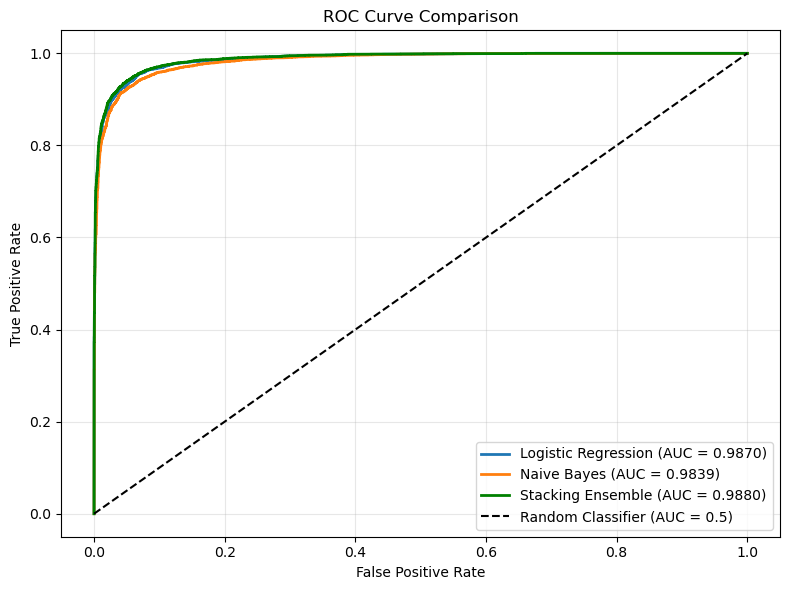

In [59]:
plt.figure(figsize=(8, 6))

plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.4f})', linewidth=2)
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {auc_nb:.4f})', linewidth=2)
plt.plot(fpr_stack, tpr_stack, label=f'Stacking Ensemble (AUC = {auc_stack:.4f})', linewidth=2, color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("roc_curve_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

In [60]:
# AUC Score Summary
auc_results = pd.DataFrame({
    'Model': ['Logistic Regression (Tuned)', 'Naive Bayes (Tuned)', 'Stacking Ensemble'],
    'AUC Score': [auc_lr, auc_nb, auc_stack]
}).sort_values('AUC Score', ascending=False)

auc_results

,Model,AUC Score
2,Stacking Ensemble,0.987958
0,Logistic Regression (Tuned),0.986993
1,Naive Bayes (Tuned),0.983878


### 9.3. Precision-Recall Curve

In [61]:
# Calculate Precision-Recall curves
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_prob_lr)
precision_nb, recall_nb, _ = precision_recall_curve(y_test, y_prob_nb)
precision_stack, recall_stack, _ = precision_recall_curve(y_test, y_prob_stack)

# Calculate Average Precision scores
ap_lr = average_precision_score(y_test, y_prob_lr)
ap_nb = average_precision_score(y_test, y_prob_nb)
ap_stack = average_precision_score(y_test, y_prob_stack)

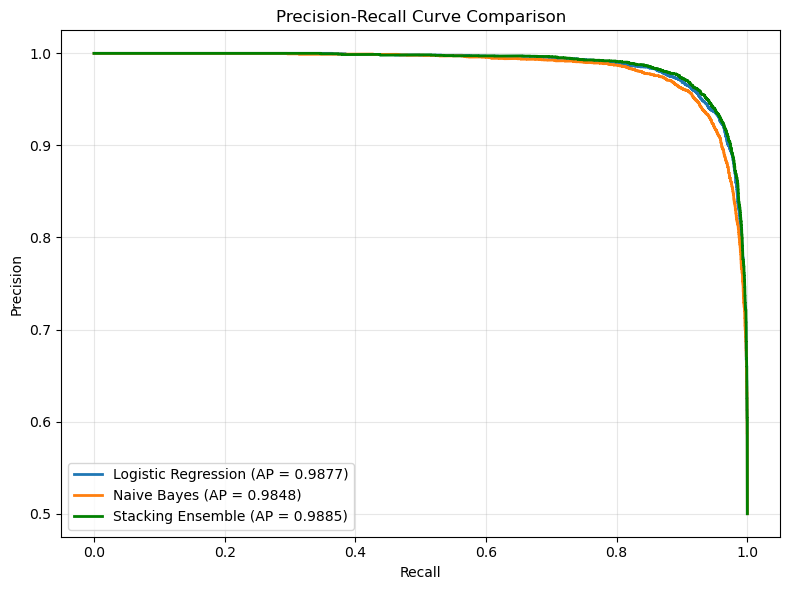

In [62]:
# Plot Precision-Recall Curves
plt.figure(figsize=(8, 6))

plt.plot(recall_lr, precision_lr, label=f'Logistic Regression (AP = {ap_lr:.4f})', linewidth=2)
plt.plot(recall_nb, precision_nb, label=f'Naive Bayes (AP = {ap_nb:.4f})', linewidth=2)
plt.plot(recall_stack, precision_stack, label=f'Stacking Ensemble (AP = {ap_stack:.4f})', linewidth=2, color='green')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("precision_recall_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

### 9.4. Final Model Comparison

In [63]:
# Comprehensive comparison of all models
final_comparison = pd.DataFrame({
    'Model': [
        "Logistic Regression",
        "Multinomial Naive Bayes",
        "Linear SVM",
        'Logistic Regression (Tuned)',
        'Naive Bayes (Tuned)',
        'Linear SVM (Tuned)',
        'Hard Voting Ensemble',
        'Soft Voting Ensemble',
        'Stacking Ensemble'
    ],
    'Accuracy': [
        acc_lr,
        acc_nb,
        acc_svm,
        acc_lr_tuned,
        acc_nb_tuned,
        acc_svm_tuned,
        acc_hard_voting,
        acc_soft_voting,
        acc_stack
    ]
}).sort_values('Accuracy', ascending=False)

final_comparison

,Model,Accuracy
8,Stacking Ensemble,0.944500
7,Soft Voting Ensemble,0.943250
6,Hard Voting Ensemble,0.943000
2,Linear SVM,0.941667
5,Linear SVM (Tuned),0.941667
3,Logistic Regression (Tuned),0.940917
4,Naive Bayes (Tuned),0.935500
0,Logistic Regression,0.935167
1,Multinomial Naive Bayes,0.933333


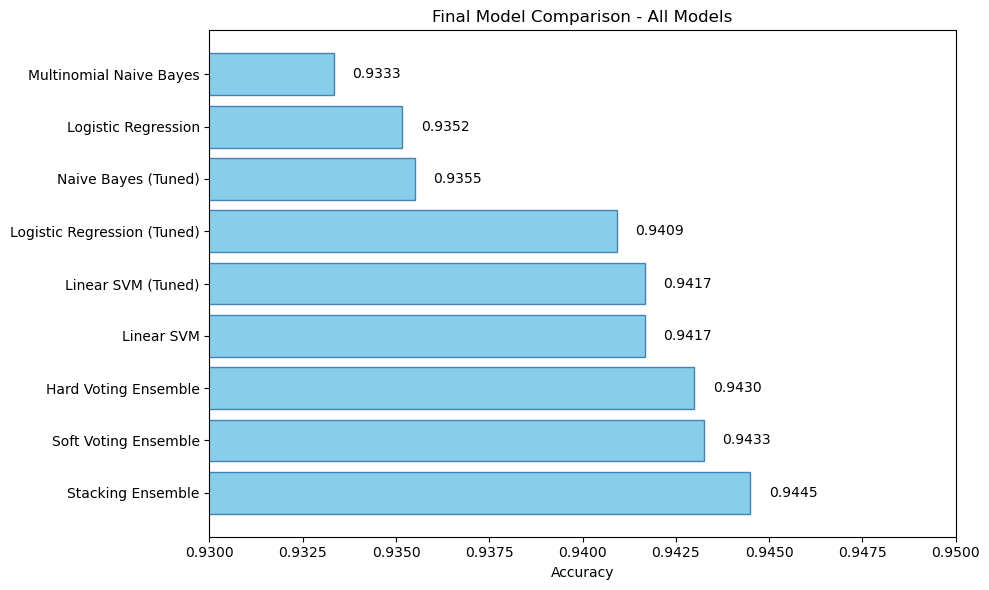


Best Model: Stacking Ensemble with Accuracy: 0.9445


In [64]:
# Final comparison visualization
plt.figure(figsize=(10, 6))

bars = plt.barh(final_comparison['Model'], final_comparison['Accuracy'], color='skyblue', edgecolor='steelblue')
plt.xlabel('Accuracy')
plt.title('Final Model Comparison - All Models')
plt.xlim(0.93, 0.95)

for bar, acc in zip(bars, final_comparison['Accuracy']):
    plt.text(acc + 0.0005, bar.get_y() + bar.get_height()/2, 
             f'{acc:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig("model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nBest Model: {final_comparison.iloc[0]['Model']} with Accuracy: {final_comparison.iloc[0]['Accuracy']:.4f}")

## 10. Model Testing on New Reviews

### 10.1. Manual Sentiment Labelling and Model Prediction

In [65]:
test_reviews = pd.DataFrame({
    "review_text": [
        "This movie was absolutely amazing, I loved the story and acting.",
        "Terrible movie, boring plot and very poor acting.",
        "The film was enjoyable and entertaining overall.",
        "Waste of time, I regret watching this movie.",
        "Some parts were slow but the movie was quite good.",
        "Very disappointing, nothing made sense.",
        "A masterpiece! One of the best films I've ever seen.",
        "Do not waste your money on this garbage.",
        "Decent movie, worth watching once.",
        "Awful experience, I walked out halfway through."
    ],
    "actual_sentiment": [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]  # 1 = Positive, 0 = Negative
})

test_reviews

,review_text,actual_sentiment
0,"This movie was absolutely amazing, I loved the...",1
1,"Terrible movie, boring plot and very poor acting.",0
2,The film was enjoyable and entertaining overall.,1
3,"Waste of time, I regret watching this movie.",0
4,Some parts were slow but the movie was quite g...,1
5,"Very disappointing, nothing made sense.",0
6,A masterpiece! One of the best films I've ever...,1
7,Do not waste your money on this garbage.,0
8,"Decent movie, worth watching once.",1
9,"Awful experience, I walked out halfway through.",0


### 10.2. Predict Sentiment Using Stacking Ensemble (Best Model)

In [66]:
# Transform review text using trained TF-IDF
test_tfidf = tfidf.transform(test_reviews["review_text"])

# Predict using Stacking Ensemble (best model)
test_reviews["predicted_sentiment"] = stacking_model.predict(test_tfidf)

# prediction probabilites
test_proba = stacking_model.predict_proba(test_tfidf)
test_reviews["confidence"] = [max(p) for p in test_proba]

# map labels to text 
test_reviews["actual_label"] = test_reviews["actual_sentiment"].map({1: "Positive", 0: "Negative"})
test_reviews["predicted_label"] = test_reviews["predicted_sentiment"].map({1: "Positive", 0: "Negative"})

# check if prediction is correct
test_reviews["correct"] = test_reviews["actual_sentiment"] == test_reviews["predicted_sentiment"]

test_reviews[["review_text", "actual_label", "predicted_label", "confidence", "correct"]]

,review_text,actual_label,predicted_label,confidence,correct
0,"This movie was absolutely amazing, I loved the...",Positive,Positive,0.980604,True
1,"Terrible movie, boring plot and very poor acting.",Negative,Negative,0.999950,True
2,The film was enjoyable and entertaining overall.,Positive,Positive,0.997526,True
3,"Waste of time, I regret watching this movie.",Negative,Negative,0.997256,True
4,Some parts were slow but the movie was quite g...,Positive,Positive,0.664978,True
5,"Very disappointing, nothing made sense.",Negative,Negative,0.999531,True
6,A masterpiece! One of the best films I've ever...,Positive,Positive,0.986956,True
7,Do not waste your money on this garbage.,Negative,Negative,0.999980,True
8,"Decent movie, worth watching once.",Positive,Positive,0.935644,True
9,"Awful experience, I walked out halfway through.",Negative,Negative,0.998065,True


## 11. Save Trained Models

In [67]:
# Save the best model (Stacking Ensemble)
joblib.dump(stacking_model, "stacking_ensemble_model.joblib")

# TF-IDF vectorizer (essential for prediction on new data)
joblib.dump(tfidf, "tfidf_vectorizer.joblib")

# other tuned models
joblib.dump(best_lr, "logistic_regression_tuned.joblib")
joblib.dump(best_nb, "naive_bayes_tuned.joblib")
joblib.dump(best_svm, "linear_svm_tuned.joblib")

['linear_svm_tuned.joblib']